In [66]:
import gymnasium as gym

In [67]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.distributions import Normal

In [68]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [69]:
num_envs = 4
env = gym.make_vec(
    "MountainCarContinuous-v0",
    render_mode = "rgb_array",
    goal_velocity = 0.1,
    num_envs = num_envs,
    vectorization_mode = "sync",
)

In [70]:
state, _ = env.reset()
state_dim = state.shape[-1]
action_dim = env.action_space.shape[-1]
print(state, env.action_space)
print(state_dim, action_dim)
action_low_bound = env.action_space.low[0].item()
action_high_bound = env.action_space.high[0].item()
print(action_low_bound, action_high_bound)

[[-0.4821268   0.        ]
 [-0.49375376  0.        ]
 [-0.5768757   0.        ]
 [-0.5911789   0.        ]] Box(-1.0, 1.0, (4, 1), float32)
2 1
-1.0 1.0


In [71]:
class ActorCritic(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(state_dim, 64),
            nn.Tanh(),
            nn.Linear(64, 64),
            nn.Tanh(),
        )
        self.actor = nn.Linear(64, action_dim + 1)
        self.critic = nn.Linear(64, 1)
    
    def forward(self, state):
        x = self.model(state)
        action = self.actor(x)
        value = self.critic(x)
        if value.shape != torch.Size([1]):
            value = value.squeeze(1)
        return action, value

In [78]:
class PPOAgent():
    def __init__(self, lr = 2.5e-4, gamma = 0.99, lamb = 0.95,
                       clip_epsilon = 0.2, epochs = 4, mb_size = 4):
        self.model = ActorCritic().to(device)
        self.optimizer = optim.Adam(self.model.parameters(), lr = lr)
        self.gamma = gamma
        self.lamb = lamb
        self.clip_epsilon = clip_epsilon
        self.epochs = epochs
        self.mb_size = mb_size

    def get_action_and_value(self, state, action = None):
        model_action, value = self.model(state)

        mu = model_action[:,0]
        log_std = model_action[:,1]
        std = torch.exp(log_std)
        
        dist = Normal(mu, std)
        
        if action is None:
            raw_action = dist.rsample()
        else:
            raw_action = torch.atanh(action)
            
        log_prob = dist.log_prob(raw_action)
        
        # Tanh correction
        log_prob -= torch.log(1 - torch.tanh(raw_action).pow(2) + 1e-8)
        
        action = torch.tanh(raw_action)
        
        return action, value, log_prob, dist.entropy()

    def calculate_advantages(self, rewards, values, last_value, masks):
        T = rewards.shape[0]
        advantages = []
        last_gae = 0
        for t in reversed(range(T)):
            next_value = last_value if t == T - 1 else values[t + 1]
            TD = rewards[t] + masks[t] * self.gamma * next_value - values[t]
            gae = last_gae = TD + masks[t] * self.gamma * self.lamb * last_gae
            advantages.insert(0, gae)
        advantages = torch.stack(advantages)
        return advantages

    def learn(self, states, last_state, actions, rewards, dones, old_values, old_log_probs):
        with torch.no_grad():
            _, last_value = self.model(last_state)
            masks = 1.0 - dones.float()
            raw_advantages = self.calculate_advantages(rewards, old_values, last_value, masks)
            advantages = (raw_advantages - raw_advantages.mean()) / (raw_advantages.std() + 1e-8)
            returns = raw_advantages + old_values
            
        def my_reshape(tensor):
            return tensor.reshape((tensor.shape[0] * tensor.shape[1], *tensor.shape[2:]))
            
        states = my_reshape(states)
        actions = my_reshape(actions)
        rewards = my_reshape(rewards)
        dones = my_reshape(dones)
        old_values = my_reshape(old_values)
        old_log_probs = my_reshape(old_log_probs)
        advantages = my_reshape(advantages)
        returns = my_reshape(returns)
        
        T = states.shape[0]
        
        for _ in range(self.epochs):
            perm = torch.randperm(T)
            for start in range(0, T, self.mb_size):
                mb_indices = perm[start:start + self.mb_size]
                
                mb_states = states[mb_indices]
                mb_actions = actions[mb_indices]
                mb_old_log_probs = old_log_probs[mb_indices]
                mb_advantages = advantages[mb_indices]
                mb_returns = returns[mb_indices]

                _, mb_values, mb_log_probs, mb_entropy = self.get_action_and_value(mb_states, action=mb_actions)
                loss_critic = nn.MSELoss()(mb_values, mb_returns)
                
                mb_ratios = torch.exp(mb_log_probs - mb_old_log_probs)
                mb_clipped_ratios = torch.clamp(mb_ratios, 1 - self.clip_epsilon, 1 + self.clip_epsilon)
                loss_actor = -torch.min(mb_ratios * mb_advantages, mb_clipped_ratios * mb_advantages).mean()
                
                loss = loss_actor + 0.5 * loss_critic - 0.1 * mb_entropy.mean()

                self.optimizer.zero_grad()
                loss.backward()
                self.optimizer.step()
# New PPO Agent
agent = PPOAgent()

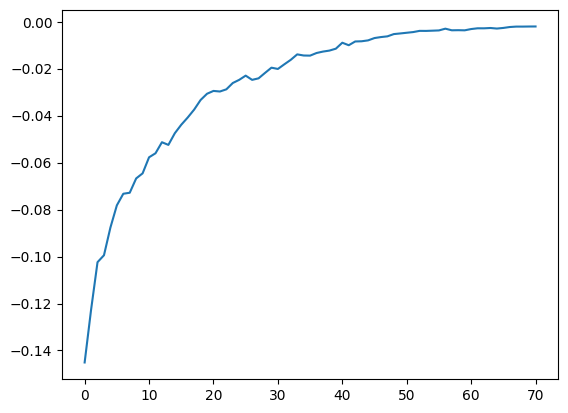

In [ ]:
import matplotlib.pyplot as plt
from IPython.display import clear_output

performance_history = []
for steps in range(1000):
    states, actions, rewards, dones, values, log_probs = [], [], [], [], [], []
    running_dones = torch.zeros(num_envs, dtype=torch.float32, device=device)
    state, _ = env.reset()
    while not running_dones.all():
        state = torch.tensor(state, dtype=torch.float32, device=device)
        with torch.no_grad():
            action, value, log_prob, _ = agent.get_action_and_value(state)
        states.append(state)
        actions.append(action)
        values.append(value)
        log_probs.append(log_prob)
        state, reward, terminated, truncated, _ = env.step(action.unsqueeze(-1).cpu())
        reward = torch.tensor(reward, dtype=torch.float32, device=device)
        terminated = torch.tensor(terminated, dtype=torch.bool, device=device)
        truncated = torch.tensor(truncated, dtype=torch.bool, device=device)
        rewards.append(reward)
        running_dones = torch.logical_or(running_dones, torch.logical_or(terminated, truncated))
        dones.append(running_dones)
    last_state = torch.tensor(state, dtype=torch.float32, device=device)
    states = torch.stack(states)
    actions = torch.stack(actions)
    rewards = torch.stack(rewards)
    dones = torch.stack(dones)
    values = torch.stack(values)
    log_probs = torch.stack(log_probs)
    agent.learn(states, last_state, actions, rewards, dones, values, log_probs)

    # Display statistics
    clear_output(wait=True)
    performance_history.append(rewards.sum(dim=1).mean().cpu())
    plt.plot(range(steps + 1), performance_history)
    plt.show()

In [ ]:
import matplotlib.pyplot as plt
from IPython.display import clear_output

def show_env(env, agent = None):
    state, _ = env.reset()
    total_reward = 0

    done = False
    while not done:
        # Render from env
        frame = env.render()   # returns RGB array (H, W, 3)

        clear_output(wait=True)
        plt.imshow(frame)
        plt.axis("off")
        plt.title(f"Reward {total_reward}")
        plt.show()

        # Take environment step
        state = torch.tensor(state, dtype=torch.float32, device=device)
        action = env.action_space.sample()
        if agent:
            with torch.no_grad():
                action, _, _, _ = agent.get_action_and_value(state.unsqueeze(0))
        state, reward, terminated, truncated, _ = env.step(action.cpu())
        total_reward += reward

        done = terminated or truncated

    print("Episode finished. Total reward:", total_reward)

env = gym.make(
    "MountainCarContinuous-v0",
    render_mode = "rgb_array",
    goal_velocity = 0.1,
)
show_env(env, agent=agent)

In [159]:
a = torch.tensor([[1, 2], [3, 4]])
a[:,0]

tensor([1, 3])